Profiling for 400 particles..
         44034 function calls (43686 primitive calls) in 8.123 seconds

   Ordered by: cumulative time
   List reduced from 651 to 8 due to restriction <8>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.172    0.172    8.123    8.123 <ipython-input-2-d1bb3d1277b7>:117(main)
      126    0.555    0.004    5.721    0.045 <ipython-input-2-d1bb3d1277b7>:90(getAcc)
      251    0.250    0.001    4.317    0.017 <ipython-input-2-d1bb3d1277b7>:64(getDensity)
      251    3.177    0.013    3.177    0.013 <ipython-input-2-d1bb3d1277b7>:13(W)
      126    2.390    0.019    2.390    0.019 <ipython-input-2-d1bb3d1277b7>:27(gradW)
      377    1.260    0.003    1.262    0.003 <ipython-input-2-d1bb3d1277b7>:42(getPairwiseSeparations)
      629    0.009    0.000    0.186    0.000 /usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:2177(sum)
      637    0.008    0.000    0.176    0.000 /usr/local/lib/python3.11/dist-p

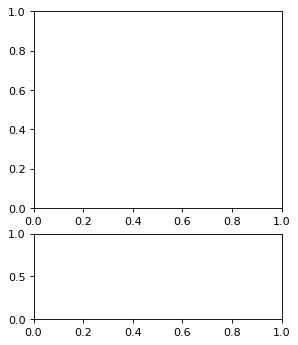

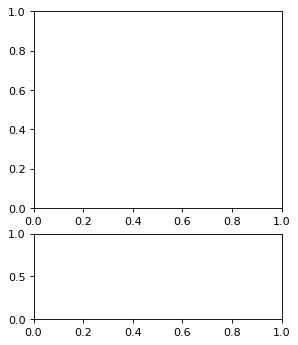

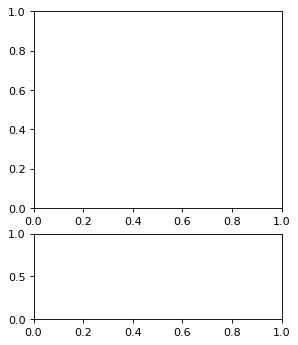

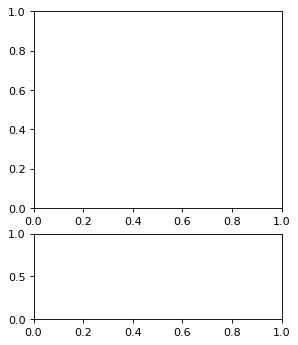

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

# If not running under kernprof, define a dummy decorator.
try:
    profile
except NameError:
    def profile(func):
        return func

@profile
def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D)
    x     is a vector/matrix of x positions
    y     is a vector/matrix of y positions
    z     is a vector/matrix of z positions
    h     is the smoothing length
    w     is the evaluated smoothing function
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    w = (1.0 / (h * np.sqrt(np.pi)))**3 * np.exp(-r**2 / h**2)
    return w

@profile
def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D)
    x, y, z  are vectors/matrices of positions
    h        is the smoothing length
    Returns: wx, wy, wz (gradients)
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    n = -2 * np.exp(-r**2 / h**2) / (h**5 * (np.pi)**(3/2))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

@profile
def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between 2 sets of coordinates.
    ri: an M x 3 matrix of positions.
    rj: an N x 3 matrix of positions.
    Returns: dx, dy, dz (each M x N matrices of separations)
    """
    M = ri.shape[0]
    N = rj.shape[0]
    # Reshape positions for broadcasting
    rix = ri[:, 0].reshape((M, 1))
    riy = ri[:, 1].reshape((M, 1))
    riz = ri[:, 2].reshape((M, 1))
    rjx = rj[:, 0].reshape((N, 1))
    rjy = rj[:, 1].reshape((N, 1))
    rjz = rj[:, 2].reshape((N, 1))
    dx = rix - rjx.T
    dy = riy - rjy.T
    dz = riz - rjz.T
    return dx, dy, dz

@profile
def getDensity(r, pos, m, h):
    """
    Get Density at sampling locations from SPH particle distribution.
    r   : an M x 3 matrix of sampling locations.
    pos : an N x 3 matrix of SPH particle positions.
    m   : particle mass.
    h   : smoothing length.
    Returns: rho, an M x 1 vector of densities.
    """
    dx, dy, dz = getPairwiseSeparations(r, pos)
    rho = np.sum(m * W(dx, dy, dz, h), axis=1).reshape((-1, 1))
    return rho

@profile
def getPressure(rho, k, n):
    """
    Equation of State.
    rho : vector of densities.
    k   : equation of state constant.
    n   : polytropic index.
    Returns: Pressure P.
    """
    P = k * rho**(1 + 1/n)
    return P

@profile
def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle.
    pos   : N x 3 matrix of positions.
    vel   : N x 3 matrix of velocities.
    m     : particle mass.
    h     : smoothing length.
    k     : equation-of-state constant.
    n     : polytropic index.
    lmbda : external force constant.
    nu    : viscosity.
    Returns: a, N x 3 matrix of accelerations.
    """
    N = pos.shape[0]
    rho = getDensity(pos, pos, m, h)
    P = getPressure(rho, k, n)
    dx, dy, dz = getPairwiseSeparations(pos, pos)
    dWx, dWy, dWz = gradW(dx, dy, dz, h)
    ax = -np.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWx, axis=1).reshape((N, 1))
    ay = -np.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWy, axis=1).reshape((N, 1))
    az = -np.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWz, axis=1).reshape((N, 1))
    a = np.hstack((ax, ay, az))
    a -= lmbda * pos   # external potential force
    a -= nu * vel      # viscosity
    return a

@profile
def main(N = 400):
    """ SPH simulation """
    # Simulation parameters
    N = N          # Number of particles
    t = 0            # Current time
    tEnd = 5        # End time
    dt = 0.04        # Timestep
    M = 2            # Star mass
    R = 0.75         # Star radius
    h = 0.1          # Smoothing length
    k = 0.1          # Equation of state constant
    n = 1            # Polytropic index
    nu = 1           # Damping/viscosity
    plotRealTime = False  # Flag for plotting as simulation proceeds

    # Generate Initial Conditions
    np.random.seed(42)
    lmbda = (2 * k * (1 + n) * np.pi**(-3/(2*n)) *
             (M * gamma(5/2+n) / R**3 / gamma(1+n))**(1/n) / R**2)
    m = M / N                    # Particle mass
    pos = np.random.randn(N, 3)  # Random initial positions
    vel = np.zeros_like(pos)     # Initial velocities (zero)

    # Calculate initial accelerations
    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)

    # Number of timesteps
    Nt = int(np.ceil(tEnd / dt))

    # Prepare figure for real-time plotting
    fig = plt.figure(figsize=(4, 5), dpi=80)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = plt.subplot(grid[0:2, 0])
    ax2 = plt.subplot(grid[2, 0])

    rr = np.zeros((100, 3))
    rlin = np.linspace(0, 1, 100)
    rr[:, 0] = rlin
    rho_analytic = lmbda / (4 * k) * (R**2 - rlin**2)

    # Simulation Main Loop
    for i in range(Nt):
        # Leapfrog integration: half-kick, drift, update acceleration, half-kick.
        vel += acc * dt / 2
        pos += vel * dt
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        vel += acc * dt / 2
        t += dt

        # Get density for plotting
        rho = getDensity(pos, pos, m, h)

        # Plot in real time (or at the final timestep)
        # if plotRealTime or (i == Nt - 1):
        #     plt.sca(ax1)
        #     plt.cla()
        #     cval = np.minimum((rho - 3) / 3, 1).flatten()
        #     plt.scatter(pos[:, 0], pos[:, 1], c=cval, cmap=plt.cm.autumn,
        #                 s=10, alpha=0.5)
        #     ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
        #     ax1.set_aspect('equal', 'box')
        #     ax1.set_xticks([-1, 0, 1])
        #     ax1.set_yticks([-1, 0, 1])
        #     ax1.set_facecolor((0.1, 0.1, 0.1))

        #     plt.sca(ax2)
        #     plt.cla()
        #     ax2.set(xlim=(0, 1), ylim=(0, 3))
        #     ax2.set_aspect(0.1)
        #     plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
        #     rho_radial = getDensity(rr, pos, m, h)
        #     plt.plot(rlin, rho_radial, color='blue')
        #     plt.pause(0.001)

    # Add labels/legend and save figure
    # plt.sca(ax2)
    # plt.xlabel('radius')
    # plt.ylabel('density')
    # plt.savefig('sph.png', dpi=240)
    # plt.show()

    return 0

if __name__ == "__main__":
    part = [400,2000,4000,8000]
    for i in part:
        print(f"Profiling for {i} particles..")
        profiler = cProfile.Profile()
        profiler.enable()  # Start profiling
        main(i)
        profiler.disable()  # Stop profiling

        # Create a Stats object and sort the results by cumulative time.
        stats = pstats.Stats(profiler).sort_stats("cumtime")
        stats.print_stats(8)


In [ ]:
import cupy as cp
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

"""
Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton University, @PMocz

Simulate the structure of a star with SPH using CuPy on GPU.
"""

# If not running under kernprof, define a dummy decorator.
try:
    profile
except NameError:
    def profile(func):
        return func

@profile
def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D) using CuPy.
    x, y, z : GPU arrays of positions
    h       : smoothing length
    Returns: evaluated smoothing function (GPU array)
    """
    r = cp.sqrt(x**2 + y**2 + z**2)
    w = (1.0/(h * cp.sqrt(cp.pi)))**3 * cp.exp(-r**2/(h**2))
    return w

@profile
def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D) using CuPy.
    Returns: wx, wy, wz (GPU arrays)
    """
    r = cp.sqrt(x**2 + y**2 + z**2)
    n = -2 * cp.exp(-r**2/(h**2)) / (h**5 * (cp.pi)**(3/2))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

@profile
def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between two sets of coordinates (GPU arrays).
    Returns: dx, dy, dz (GPU arrays)
    """
    M = ri.shape[0]
    N = rj.shape[0]
    # Reshape for broadcasting
    rix = ri[:, 0].reshape((M, 1))
    riy = ri[:, 1].reshape((M, 1))
    riz = ri[:, 2].reshape((M, 1))
    rjx = rj[:, 0].reshape((N, 1))
    rjy = rj[:, 1].reshape((N, 1))
    rjz = rj[:, 2].reshape((N, 1))
    dx = rix - rjx.T
    dy = riy - rjy.T
    dz = riz - rjz.T
    return dx, dy, dz

@profile
def getDensity(r, pos, m, h):
    """
    Get Density at sampling locations from SPH particle distribution.
    All arrays are GPU arrays.
    """
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations(r, pos)
    rho = cp.sum(m * W(dx, dy, dz, h), axis=1).reshape((M, 1))
    return rho

@profile
def getPressure(rho, k, n):
    """
    Equation of State: P = k * rho^(1+1/n)
    """
    P = k * rho**(1+1/n)
    return P

@profile
def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle.
    All arrays are GPU arrays.
    """
    N = pos.shape[0]
    rho = getDensity(pos, pos, m, h)
    P = getPressure(rho, k, n)
    dx, dy, dz = getPairwiseSeparations(pos, pos)
    dWx, dWy, dWz = gradW(dx, dy, dz, h)
    ax = -cp.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWx, axis=1).reshape((N,1))
    ay = -cp.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWy, axis=1).reshape((N,1))
    az = -cp.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWz, axis=1).reshape((N,1))
    a = cp.hstack((ax, ay, az))
    a -= lmbda * pos
    a -= nu * vel
    return a

@profile
def main(N=400):
    """
    SPH simulation using CuPy.
    """
    t = 0
    tEnd = 5
    dt = 0.04
    M = 1
    R = 0.75
    h = 0.1
    k = 0.1
    n = 1
    nu = 0.001
    plotRealTime = True

    cp.random.seed(42)
    # Compute lmbda on GPU. Note: gamma is computed on CPU; for one-time computation it's acceptable.
    lmbda = 2*k*(1+n)*cp.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m = M/N
    pos = cp.random.randn(N, 3)
    vel = cp.zeros((N, 3), dtype=cp.double)

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
    Nt = int(cp.ceil(tEnd/dt))

    # Prepare plotting: create CPU arrays for rlin, etc.
    # fig = plt.figure(figsize=(4,5), dpi=100)
    # grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    # ax1 = plt.subplot(grid[0:2,0])
    # ax2 = plt.subplot(grid[2,0])
    rr = cp.zeros((100,3), dtype=cp.double)
    rlin = cp.linspace(0, 1, 100)
    rr[:,0] = rlin
    rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)

    for i in range(Nt):
        vel += acc * dt/2
        pos += vel * dt
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        vel += acc * dt/2
        t += dt
        rho = getDensity(pos, pos, m, h)
        # if plotRealTime or (i == Nt - 1):
        #     # Convert GPU arrays to CPU arrays for plotting.
        #     pos_cpu = cp.asnumpy(pos)
        #     rho_cpu = cp.asnumpy(rho)
        #     rlin_cpu = cp.asnumpy(rlin)
        #     rho_analytic_cpu = cp.asnumpy(rho_analytic)
        #     # Use cp.minimum on the GPU; then convert the result.
        #     cval = cp.minimum((rho - 3)/3, cp.array(1, dtype=rho.dtype)).flatten().get()

        #     plt.sca(ax1)
        #     plt.cla()
        #     plt.scatter(pos_cpu[:,0], pos_cpu[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
        #     ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
        #     ax1.set_aspect('equal', 'box')
        #     ax1.set_xticks([-1,0,1])
        #     ax1.set_yticks([-1,0,1])
        #     ax1.set_facecolor((0.1,0.1,0.1))

        #     plt.sca(ax2)
        #     plt.cla()
        #     ax2.set(xlim=(0,1), ylim=(0,3))
        #     ax2.set_aspect(0.1)
        #     plt.plot(rlin_cpu, rho_analytic_cpu, color='gray', linewidth=2)
        #     # Compute radial density and convert to CPU
        #     rho_radial = getDensity(rr, pos, m, h)
        #     plt.plot(rlin_cpu, cp.asnumpy(rho_radial), color='blue')
        #     # plt.pause(0.001)

    # plt.sca(ax2)
    # plt.xlabel('radius')
    # plt.ylabel('density')
    # plt.savefig('sph.png', dpi=1920)
    # plt.show()  # Uncomment to display the figure interactively.
    return 0

if __name__ == "__main__":
    part = [400,2000,4000,8000]
    for i in part:
        print(f"Profiling for {i} particles..")
        profiler = cProfile.Profile()
        profiler.enable()  # Start profiling
        main(i)
        profiler.disable()  # Stop profiling

        # Create a Stats object and sort the results by cumulative time.
        stats = pstats.Stats(profiler).sort_stats("cumtime")
        stats.print_stats(8)


Profiling for 400 particles..
         18802 function calls in 0.436 seconds

   Ordered by: cumulative time
   List reduced from 60 to 8 due to restriction <8>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.036    0.036    0.436    0.436 <ipython-input-8-bda2b63d5591>:103(main)
      126    0.093    0.001    0.315    0.002 <ipython-input-8-bda2b63d5591>:84(getAcc)
      251    0.010    0.000    0.179    0.001 <ipython-input-8-bda2b63d5591>:65(getDensity)
      251    0.126    0.001    0.127    0.001 <ipython-input-8-bda2b63d5591>:20(W)
      126    0.072    0.001    0.073    0.001 <ipython-input-8-bda2b63d5591>:32(gradW)
      377    0.035    0.000    0.041    0.000 <ipython-input-8-bda2b63d5591>:45(getPairwiseSeparations)
      629    0.001    0.000    0.030    0.000 /usr/local/lib/python3.11/dist-packages/cupy/_math/sumprod.py:11(sum)
      629    0.029    0.000    0.029    0.000 {method 'sum' of 'cupy._core.core._ndarray_base' objects}


Pro

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

"""
Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton University, @PMocz

This version uses TensorFlow for GPU acceleration.
"""

# If not running under kernprof, define a dummy decorator.
try:
    profile
except NameError:
    def profile(func):
        return func

@profile
def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D) using TensorFlow.
    x, y, z : TensorFlow tensors (GPU arrays) representing positions.
    h       : smoothing length (scalar)
    Returns : Tensor of kernel values.
    """
    r = tf.math.sqrt(x**2 + y**2 + z**2)
    pi_const = tf.constant(np.pi, dtype=x.dtype)
    factor = (1.0 / (h * tf.math.sqrt(pi_const)))**3
    w = factor * tf.math.exp(-r**2 / (h**2))
    return w

@profile
def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D) using TensorFlow.
    Returns 3 tensors: wx, wy, wz.
    """
    r = tf.math.sqrt(x**2 + y**2 + z**2)
    pi_const = tf.constant(np.pi, dtype=x.dtype)
    n = -2 * tf.math.exp(-r**2 / (h**2)) / (h**5 * tf.math.pow(pi_const, 1.5))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

@profile
def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between two sets of coordinates.
    ri: Tensor of shape [M, 3]
    rj: Tensor of shape [N, 3]
    Returns:
         dx, dy, dz : each a tensor of shape [M, N].
    """
    rix = tf.expand_dims(ri[:, 0], axis=1)  # shape [M, 1]
    riy = tf.expand_dims(ri[:, 1], axis=1)
    riz = tf.expand_dims(ri[:, 2], axis=1)
    rjx = tf.expand_dims(rj[:, 0], axis=0)   # shape [1, N]
    rjy = tf.expand_dims(rj[:, 1], axis=0)
    rjz = tf.expand_dims(rj[:, 2], axis=0)
    dx = rix - rjx
    dy = riy - rjy
    dz = riz - rjz
    return dx, dy, dz

@profile
def getDensity(r, pos, m, h):
    """
    Get density at sampling locations from the SPH particle distribution.
    r: Tensor of shape [M, 3] (sampling locations)
    pos: Tensor of shape [N, 3] (particle positions)
    m: particle mass (scalar, as a tf.constant)
    h: smoothing length (scalar)
    Returns:
         rho: Tensor of shape [M, 1]
    """
    dx, dy, dz = getPairwiseSeparations(r, pos)
    w = W(dx, dy, dz, h)
    rho = tf.reduce_sum(m * w, axis=1, keepdims=True)
    return rho

@profile
def getPressure(rho, k, n):
    """
    Equation of State: P = k * rho^(1 + 1/n)
    """
    P = k * tf.pow(rho, 1.0 + 1.0/n)
    return P

@profile
def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle.
    pos, vel: Tensors of shape [N, 3]
    m: particle mass (scalar tf.constant)
    h: smoothing length (scalar)
    k: equation-of-state constant (scalar)
    n: polytropic index (integer)
    lmbda: external force constant (scalar tf.constant)
    nu: viscosity (scalar)
    Returns:
         a: Tensor of shape [N, 3]
    """
    rho = getDensity(pos, pos, m, h)       # [N, 1]
    P = getPressure(rho, k, n)             # [N, 1]
    dx, dy, dz = getPairwiseSeparations(pos, pos)  # each [N, N]
    dWx, dWy, dWz = gradW(dx, dy, dz, h)           # each [N, N]
    term1 = P / tf.pow(rho, 2)             # [N, 1]
    term_total = term1 + tf.transpose(term1)  # [N, N]
    ax = -tf.reduce_sum(m * term_total * dWx, axis=1, keepdims=True)
    ay = -tf.reduce_sum(m * term_total * dWy, axis=1, keepdims=True)
    az = -tf.reduce_sum(m * term_total * dWz, axis=1, keepdims=True)
    a = tf.concat([ax, ay, az], axis=1)
    a = a - lmbda * pos - nu * vel
    return a

@profile
def main(N=400):
    """
    SPH simulation using TensorFlow.
    """
    t = 0.0
    tEnd = 5.0
    dt = 0.04
    M = 1.0
    R = 0.75
    h = 0.1
    k = 0.1
    n = 1
    nu = 0.001
    plotRealTime = True

    # Use TensorFlow's random generator.
    tf.random.set_seed(42)

    # Compute lmbda using scipy.special.gamma (CPU) and convert to tf.float32.
    lmbda_val = 2*k*(1+n)* (np.pi**(-3/(2*n))) * ((M*gamma(5/2+n))/(R**3)/gamma(1+n))**(1/n) / R**2
    lmbda = tf.constant(lmbda_val, dtype=tf.float32)
    m_val = M / N
    m_const = tf.constant(m_val, dtype=tf.float32)

    pos = tf.random.normal([N, 3], dtype=tf.float32)
    vel = tf.zeros([N, 3], dtype=tf.float32)

    acc = getAcc(pos, vel, m_const, h, k, n, lmbda, nu)
    Nt = int(np.ceil(tEnd/dt))

    # Prepare plotting data (these will be converted to CPU arrays for Matplotlib).
    # fig = plt.figure(figsize=(4,5), dpi=100)
    # ax1 = plt.subplot(211)
    # ax2 = plt.subplot(212)
    # Create a tensor rr of shape [100, 3] with rr[:,0] = linspace(0,1) and zeros elsewhere.
    rlin = tf.linspace(0.0, 1.0, 100)
    rr = tf.concat([tf.reshape(rlin, [-1, 1]), tf.zeros([100, 2], dtype=tf.float32)], axis=1)
    rho_analytic = lmbda/(4*k) * (R**2 - tf.pow(rlin, 2))  # shape [100]

    for i in range(Nt):
        vel = vel + acc * (dt/2)
        pos = pos + vel * dt
        acc = getAcc(pos, vel, m_const, h, k, n, lmbda, nu)
        vel = vel + acc * (dt/2)
        t += dt
        rho = getDensity(pos, pos, m_const, h)
        # if plotRealTime or (i == Nt - 1):
        #     # Convert TensorFlow tensors (on GPU) to NumPy arrays.
        #     pos_cpu = pos.numpy()
        #     rho_cpu = rho.numpy()
        #     rlin_cpu = rlin.numpy()
        #     rho_analytic_cpu = rho_analytic.numpy()
        #     # Use tf.minimum on GPU then convert to NumPy.
        #     cval = tf.minimum((rho - 3)/3, 1.0)
        #     cval_cpu = cval.numpy().flatten()

        #     ax1.cla()
        #     ax1.scatter(pos_cpu[:,0], pos_cpu[:,1], c=cval_cpu, cmap='autumn', s=10, alpha=0.5)
        #     ax1.set_xlim(-1.4, 1.4)
        #     ax1.set_ylim(-1.2, 1.2)
        #     ax1.set_aspect('equal', 'box')
        #     ax1.set_xticks([-1, 0, 1])
        #     ax1.set_yticks([-1, 0, 1])
        #     ax1.set_facecolor('black')

        #     ax2.cla()
        #     ax2.set_xlim(0,1)
        #     ax2.set_ylim(0,3)
        #     ax2.set_aspect('equal')
        #     ax2.plot(rlin_cpu, rho_analytic_cpu, color='gray', linewidth=2)
        #     rho_radial = getDensity(rr, pos, m_const, h)
        #     ax2.plot(rlin_cpu, rho_radial.numpy().flatten(), color='blue')
        #     plt.pause(0.001)

    # ax2.set_xlabel('radius')
    # ax2.set_ylabel('density')
    # plt.savefig('sph_tf.png', dpi=1920)
    # plt.show()  # Uncomment to display the figure interactively.
    return 0

if __name__ == "__main__":
    # part = [400,2000,4000,8000]
    part = [2000]
    for i in part:
        print(f"Profiling for {i} particles..")
        profiler = cProfile.Profile()
        profiler.enable()  # Start profiling
        main(i)
        profiler.disable()  # Stop profiling

        # Create a Stats object and sort the results by cumulative time.
        stats = pstats.Stats(profiler).sort_stats("cumtime")
        stats.print_stats(8)


Profiling for 20000 particles..


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy profiling decorator if not running kernprof
try:
    profile
except NameError:
    def profile(func):
        return func

@profile
def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D) using PyTorch.
    x, y, z : torch tensors representing positions.
    h       : smoothing length (scalar, float)
    Returns : Tensor of kernel values.
    """
    r = torch.sqrt(x**2 + y**2 + z**2)
    # Create a constant for pi on the correct device and dtype
    pi_const = torch.tensor(np.pi, dtype=x.dtype, device=x.device)
    factor = (1.0 / (h * torch.sqrt(pi_const)))**3
    w = factor * torch.exp(-r**2 / (h**2))
    return w

@profile
def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D) using PyTorch.
    Returns 3 tensors: wx, wy, wz.
    """
    r = torch.sqrt(x**2 + y**2 + z**2)
    pi_const = torch.tensor(np.pi, dtype=x.dtype, device=x.device)
    n = -2 * torch.exp(-r**2 / (h**2)) / (h**5 * torch.pow(pi_const, 1.5))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

@profile
def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between two sets of coordinates.
    ri: Tensor of shape [M, 3]
    rj: Tensor of shape [N, 3]
    Returns:
         dx, dy, dz : each a tensor of shape [M, N].
    """
    rix = ri[:, 0].unsqueeze(1)  # shape [M, 1]
    riy = ri[:, 1].unsqueeze(1)
    riz = ri[:, 2].unsqueeze(1)
    rjx = rj[:, 0].unsqueeze(0)  # shape [1, N]
    rjy = rj[:, 1].unsqueeze(0)
    rjz = rj[:, 2].unsqueeze(0)
    dx = rix - rjx
    dy = riy - rjy
    dz = riz - rjz
    return dx, dy, dz

@profile
def getDensity(r, pos, m, h):
    """
    Get density at sampling locations from SPH particle distribution.
    r   : Tensor of shape [M, 3] (sampling locations)
    pos : Tensor of shape [N, 3] (particle positions)
    m   : particle mass (scalar torch.tensor)
    h   : smoothing length (scalar)
    Returns:
         rho: Tensor of shape [M, 1]
    """
    dx, dy, dz = getPairwiseSeparations(r, pos)
    rho = torch.sum(m * W(dx, dy, dz, h), dim=1, keepdim=True)
    return rho

@profile
def getPressure(rho, k, n):
    """
    Equation of State: P = k * rho^(1 + 1/n)
    """
    P = k * torch.pow(rho, 1.0 + 1.0/n)
    return P

@profile
def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle using PyTorch.
    pos, vel: Tensors of shape [N, 3]
    m: particle mass (scalar torch.tensor)
    h: smoothing length (scalar)
    k: equation-of-state constant (scalar)
    n: polytropic index (integer)
    lmbda: external force constant (scalar torch.tensor)
    nu: viscosity (scalar)
    Returns:
         a: Tensor of shape [N, 3]
    """
    rho = getDensity(pos, pos, m, h)           # [N, 1]
    P = getPressure(rho, k, n)                 # [N, 1]
    dx, dy, dz = getPairwiseSeparations(pos, pos)  # each [N, N]
    dWx, dWy, dWz = gradW(dx, dy, dz, h)           # each [N, N]
    # Compute term for pair interactions:
    term = P / (rho**2)                        # [N, 1]
    term_total = term + term.transpose(0, 1)   # [N, N]
    ax = -torch.sum(m * term_total * dWx, dim=1, keepdim=True)
    ay = -torch.sum(m * term_total * dWy, dim=1, keepdim=True)
    az = -torch.sum(m * term_total * dWz, dim=1, keepdim=True)
    a = torch.cat((ax, ay, az), dim=1)
    a = a - lmbda * pos - nu * vel
    return a

@profile
def main(N=400):
    """
    SPH simulation using PyTorch for GPU acceleration.
    """
    # Simulation parameters
    t = 0.0
    tEnd = 5.0
    dt = 0.04
    M = 1.0
    R = 0.75
    h = 0.1
    k = 0.1
    n = 1
    nu = 0.001
    plotRealTime = False  # Disable plotting for benchmarking

    torch.manual_seed(42)

    # Compute lmbda and m values
    lmbda_val = 2 * k * (1+n) * (np.pi**(-3/(2*n))) * ((M*gamma(5/2+n))/(R**3)/gamma(1+n))**(1/n) / R**2
    lmbda = torch.tensor(lmbda_val, dtype=torch.float32, device=device)
    m_val = M / N
    m_const = torch.tensor(m_val, dtype=torch.float32, device=device)

    # Initialize positions and velocities on the chosen device
    pos = torch.randn((N, 3), dtype=torch.float32, device=device)
    vel = torch.zeros((N, 3), dtype=torch.float32, device=device)

    # Compute initial acceleration
    acc = getAcc(pos, vel, m_const, h, k, n, lmbda, nu)
    Nt = int(np.ceil(tEnd/dt))

    # (Optional) Plotting is disabled for performance benchmarking.
    # If you wish to plot, you would need to convert tensors to CPU arrays.

    for i in range(Nt):
        vel = vel + acc * (dt/2)
        pos = pos + vel * dt
        acc = getAcc(pos, vel, m_const, h, k, n, lmbda, nu)
        vel = vel + acc * (dt/2)
        t += dt
        # Optionally, compute density for analysis (omitted plotting here)
        rho = getDensity(pos, pos, m_const, h)
        # Optionally print or log rho statistics if needed.

    return 0

if __name__ == "__main__":
    # For testing: run simulation with a specified number of particles.
    # You can change N to 400, 2000, etc.
    part = [400,2000,4000,8000]
    for i in part:
      print(f"Profiling for {i} particles using PyTorch on device: {device} ..")
      profiler = cProfile.Profile()
      profiler.enable()
      main(i)
      profiler.disable()
      stats = pstats.Stats(profiler).sort_stats("cumtime")
      stats.print_stats(8)


Profiling for 400 particles using PyTorch on device: cuda ..
         15545 function calls (15542 primitive calls) in 0.750 seconds

   Ordered by: cumulative time
   List reduced from 201 to 8 due to restriction <8>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.010    0.010    0.750    0.750 <ipython-input-2-9490df319eed>:117(main)
      126    0.022    0.000    0.439    0.003 <ipython-input-2-9490df319eed>:89(getAcc)
      251    0.005    0.000    0.385    0.002 <ipython-input-2-9490df319eed>:66(getDensity)
      251    0.110    0.000    0.264    0.001 <ipython-input-2-9490df319eed>:17(W)
      379    0.194    0.001    0.225    0.001 {built-in method torch.tensor}
     2136    0.002    0.000    0.107    0.000 /usr/local/lib/python3.11/dist-packages/torch/_tensor.py:33(wrapped)
      377    0.080    0.000    0.091    0.000 <ipython-input-2-9490df319eed>:46(getPairwiseSeparations)
     1885    0.067    0.000    0.067    0.000 {method 'pow' of '